The purpose of the notebook is to demonstrate the estimation of Anscombe parameters for mixed-noise signal system.
* Gaussian noise mean and standard deviation
* Poisson noise multiplier "alpha"

Reference:
1. M. Mäkitalo and A. Foi, "Optimal inversion of the generalized anscombe transformation for Poisson-Gaussian noise," IEEE Trans. Image Process. **22**, 91–103 (2013).
2. C. H. Camp Jr, Y. J. Lee, and M. T. Cicerone, "Quantitative, comparable coherent anti-Stokes Raman scattering (CARS) spectroscopy: correcting errors in phase retrieval," J. Raman Spectrosc. **47**, 408–415 (2016). **Especially, see the Supplemental Informtation.**

In [1]:
import numpy as np

from scipy.signal import medfilt, savgol_filter as sgo

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['legend.loc'] = 'best'

from crikit.preprocess.standardize import calc_anscombe_parameters
from crikit.preprocess.algorithms.anscombe import gen_anscombe_inverse_closed_form, gen_anscombe_forward

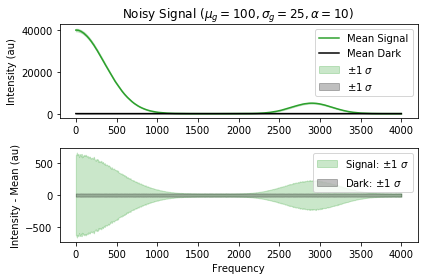

In [2]:
def mix_noise(data, g_mean, g_std, p_multi):
    """ Generate a mixed noise data from input data """
    if p_multi == 0:  # No Poisson noise
        return data + g_std*np.random.randn(*data.shape) + g_mean
    else:
        return p_multi*np.random.poisson(data) + g_std*np.random.randn(*data.shape) + g_mean

def plot_mean_std_dev(x,y_noisy, m_std_devs=1, alpha=0.25, color='C0', axis=0, sub_mean=False, label=None, ax=None):
    """ Plot mean as a line and +/- m std dev as patch """
    if ax:
        plt.sca(ax)
    mu = y_noisy.mean(axis=axis)
    std = y_noisy.std(axis=axis)
    
    if not sub_mean:
        plt.plot(x, mu, color=color, label='Mean {}'.format(label))
        plt.fill_between(x, mu-m_std_devs*std, mu+m_std_devs*std, color=color, 
                         alpha=alpha, label=r'$\pm${} $\sigma$'.format(m_std_devs))
        plt.gca().set_rasterized(True)
    else:
#         plt.plot(x, 0*mu, color=color)
        plt.fill_between(x, -m_std_devs*std, +m_std_devs*std, 
                         color=color, alpha=alpha, label=r'{}: $\pm${} $\sigma$'.format(label, m_std_devs))
    
np.random.seed(0)
n_spectra = 1000  # number of indep. spectra
n_lambda = 901  # number of wavelengths in each spectrum

f = np.linspace(0,4000,n_lambda)  # Frequency (au)
y = 40e2*np.exp(-f**2/(2*350**2)) + 50e1*np.exp(-(f-2900)**2/(2*250**2))   # signal

g_mean = 100
g_std = 25
p_alpha = 10

y_noisy = mix_noise(np.dot(np.ones((n_spectra,1)),y[None,:]), g_mean, g_std, p_alpha)
dark = mix_noise(np.dot(np.ones((n_spectra,1)),y[None,:]), g_mean, g_std, 0) - y[None,:]

fig, ax = plt.subplots(2)
plot_mean_std_dev(f, y_noisy, 1, color='C2', label='Signal', sub_mean=False, ax=ax[0])
plot_mean_std_dev(f, dark, 1, color='k', label='Dark', sub_mean=False, ax=ax[0])
plt.legend()

plot_mean_std_dev(f, y_noisy, 1, color='C2', label='Signal', sub_mean=True, ax=ax[1])
plot_mean_std_dev(f, dark, 1, color='k', label='Dark', sub_mean=True, ax=ax[1])
plt.legend()

plt.sca(ax[0])
plt.ylabel('Intensity (au)')
plt.title('Noisy Signal' + r' ($\mu_g={}, \sigma_g={}, \alpha={}$)'.format(g_mean, g_std, p_alpha))

plt.sca(ax[1])
plt.xlabel('Frequency')
plt.ylabel('Intensity - Mean (au)')

plt.tight_layout()

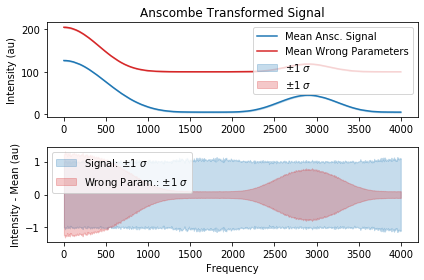

In [3]:
y_ansc = gen_anscombe_forward(y_noisy, g_std, g_mean, p_alpha)
y_ansc_wrong = gen_anscombe_forward(y_noisy, g_std*10, g_mean-10, p_alpha/2)

fig, ax = plt.subplots(2)
plot_mean_std_dev(f, y_ansc, 1, color='C0', label='Ansc. Signal', sub_mean=False, ax=ax[0])
plot_mean_std_dev(f, y_ansc_wrong, 1, color='C3', label='Wrong Parameters', sub_mean=False, ax=ax[0])
plt.legend()

plot_mean_std_dev(f, y_ansc, 1, color='C0', label='Signal', sub_mean=True, ax=ax[1])
plot_mean_std_dev(f, y_ansc_wrong, 1, color='C3', label='Wrong Param.', sub_mean=True, ax=ax[1])
plt.legend(loc='upper left')

plt.sca(ax[0])
plt.ylabel('Intensity (au)')
plt.title('Anscombe Transformed Signal')

plt.sca(ax[1])
plt.xlabel('Frequency')
plt.ylabel('Intensity - Mean (au)')

plt.tight_layout()

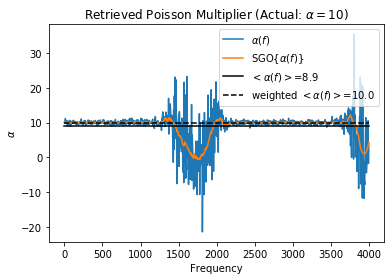

In [4]:
alpha_guess = calc_anscombe_parameters(dark, y_noisy, rng=None)['alpha']
weighted_alpha_guess = calc_anscombe_parameters(dark, y_noisy, rng=None)['weighted_mean_alpha']

plt.plot(f, alpha_guess, label=r'$\alpha(f)$')
plt.plot(f, sgo(alpha_guess,51,3), label=r'SGO{$\alpha(f)$}')
plt.plot(f, alpha_guess.mean()+0*f,'k', label=r'$<\alpha(f)>$={:.1f}'.format(alpha_guess.mean()))
plt.plot(f, weighted_alpha_guess+0*f,'k--', label=r'weighted $<\alpha(f)>$={:.1f}'.format(weighted_alpha_guess))
plt.legend()
plt.title('Retrieved Poisson Multiplier' + r' (Actual: $\alpha={}$)'.format(p_alpha))

plt.xlabel('Frequency')
plt.ylabel(r'$\alpha$')

plt.show()

In [5]:
np.allclose(calc_anscombe_parameters(dark, y_noisy, rng=None)['g_mean'].mean(), g_mean, rtol=1e-2)



True